# Week 1 test for ai-for-medical-diagnosis

### repaired to make it work for tensorflow 2

#### so much was broken that I had to strip the notebook down to its essence

#### also, only **one** of the images in valid_df was provided in the original 'data/nih/images-small/', so I downloaded the enormous archive.zip from the NIH and pulled the missing images

I started this project on my MacBook Pro but its little, fake GPU was overwhelmed so I moved to AWS and ran it on a g6.8xlarge

George Fisher October 2024

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

import os
from PIL import Image

In [2]:
tf.__version__

'2.17.0'

In [3]:
import platform
import socket
import os

def check_environment():
    # Check environment variables
    if 'AWS_EXECUTION_ENV' in os.environ:
        return "AWS"
    
    # Check hostname patterns for AWS
    hostname = socket.gethostname()
    if 'ip-' in hostname or 'ec2-' in hostname:
        return "AWS"
    
    # Check for MacOS
    if platform.system() == 'Darwin':
        return "Mac"

    return "Unknown"

environment = check_environment()
print(f"Running environment: {environment}")

Running environment: AWS


In [4]:
import tensorflow as tf

def check_device():
    devices = tf.config.list_physical_devices()
    gpu_devices = tf.config.list_physical_devices('GPU')
    
    if gpu_devices:
        print(f"Running on GPU(s): {[device.name for device in gpu_devices]}")
    elif any("Apple" in device.device_type for device in devices):
        print("Running on Apple Metal (M1/M2 or later Apple Silicon).")
    else:
        print("Running on CPU.")
    
    return devices

devices = check_device()

Running on GPU(s): ['/physical_device:GPU:0']


In [5]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']
len(labels)

14

In [6]:
# Load the dataframes
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df  = pd.read_csv("data/nih/test.csv")

In [7]:
import cv2

# Read the image using OpenCV
image_path = "data/nih/images-small/"+train_df.iloc[0,0]
image = cv2.imread(image_path)

# Get the shape of the image
original_image_shape = image.shape
print(f"(height, width, channels): {original_image_shape = }")

(height, width, channels): original_image_shape = (1024, 1024, 3)


# Set Options

In [8]:
# Set your desired target image width and height here
target_w, target_h = 320,320

# choose to create the datasets from scratch
create_new_datasets = False

# Set your desired batch size
batch_size = 16

# Weighted Loss Functions

In [9]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels/N ,axis=0)
    negative_frequencies = 1-np.sum(labels/N ,axis=0)

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [10]:
freq_pos, freq_neg = compute_class_freqs(train_df.loc[:,labels])
freq_pos

Cardiomegaly          0.020
Emphysema             0.013
Effusion              0.128
Hernia                0.002
Infiltration          0.175
Mass                  0.045
Nodule                0.054
Atelectasis           0.106
Pneumothorax          0.038
Pleural_Thickening    0.021
Pneumonia             0.010
Fibrosis              0.014
Edema                 0.016
Consolidation         0.033
dtype: float64

In [11]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [12]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Create a custom weighted loss function.

    Args:
    - pos_weights: Weight for positive samples.
    - neg_weights: Weight for negative samples.

    Returns:
    - A weighted loss function.
    """
    def weighted_loss(y_true, y_pred):
        # Calculate the proportion of positive and negative samples in the batch
        # Use TensorFlow operations instead of NumPy operations
        
        # initialize loss to zero
        loss = 0.0

        # Calculate positive and negative weights
#         w_p = np.sum(y_true == 0, axis=0) / y_true.shape[0]
#         w_n = np.sum(y_true == 1, axis=0) / y_true.shape[0]

        # Convert to keras-speak
        import tensorflow.keras.backend as K

        w_p = K.sum(K.cast(K.equal(y_true, 0), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        w_n = K.sum(K.cast(K.equal(y_true, 1), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            
            pos = -1 * w_p * y_true * tf.keras.backend.log(y_pred + epsilon)
            
            neg = -1 * w_n * (1 - y_true) * tf.keras.backend.log((1 - y_pred + epsilon))
            
            loss += pos + neg
            
        return tf.keras.backend.mean(loss)
            
    
    return weighted_loss

## Frequency of the diseases

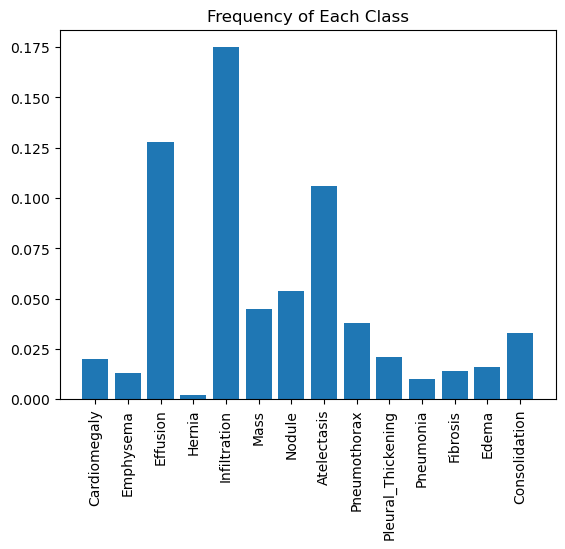

In [13]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_df.loc[:,labels], axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss.

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive.

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero).

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

## Pre-Weighted Label Frequency

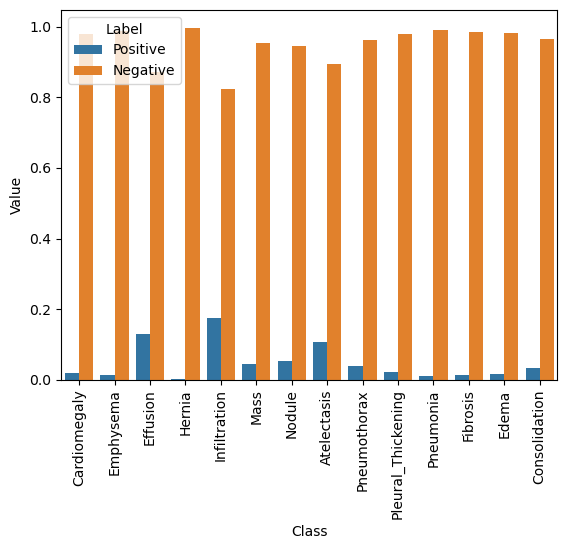

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.

To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

## Post-Weighted Label Frequency

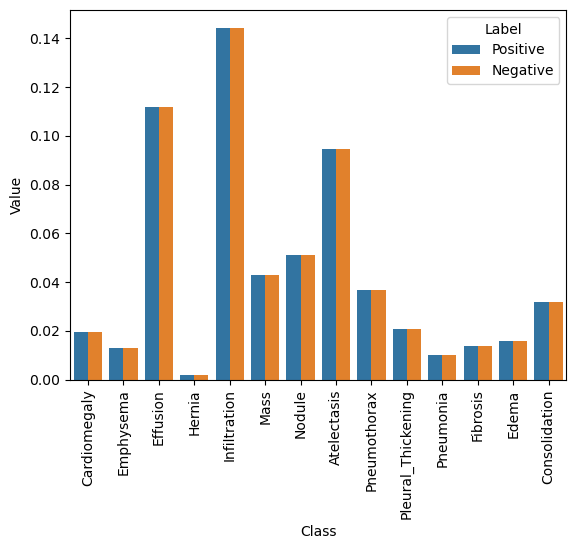

In [15]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
#                         for l,v in enumerate(neg_contribution)], ignore_index=True)
new_rows = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(neg_contribution)])
data = pd.concat([data, new_rows], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

# Create the DataSets

In [16]:
%%time

if create_new_datasets:
    # a) Eliminate leakage by removing duplicate PatientIds from train_df that are in valid_df and test_df
    unique_valid_patient_ids = valid_df['PatientId'].unique()
    train_df = train_df[~train_df['PatientId'].isin(unique_valid_patient_ids)]
    
    unique_test_patient_ids = test_df['PatientId'].unique()
    train_df = train_df[~train_df['PatientId'].isin(unique_test_patient_ids)]
    
    # Define the image directory path
    image_dir = "data/nih/images-small/"
    
    # b) Normalize images
    def normalize_image(image):
    
        x = tf.keras.preprocessing.image.img_to_array(image)
        # expand_dims is incompatible with .batch(batch_size)
        #x = np.expand_dims(x, axis=0)
        
        x = tf.keras.applications.densenet.preprocess_input(x)
        
        return x
    
    # c) Resize images to (target_w, target_h)
    
    
    def process_image(image_path):
        try:
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(target_w, target_h))
            image = normalize_image(image)
            return image
        except Exception as e:
            print(f"Warning: Could not process image at {image_path}. Error: {e}")
            return None
    
    # Helper function to create datasets and track missing images
    def create_dataset(df, labels, image_dir):
        image_paths = [os.path.join(image_dir, img) for img in df["Image"]]
        processed_images = []
        label_values = []
        missing_images_count = 0  # Initialize counter for missing images
        found_images_count = 0
    
        for img_path, label in zip(image_paths, df[labels].values):
            if os.path.exists(img_path):
                processed_image = process_image(img_path)
                if processed_image is not None:
                    processed_images.append(processed_image)
                    label_values.append(label)
                    found_images_count += 1
            else:
                print(f"Warning: Image not found at {img_path}")
                missing_images_count += 1  # Increment counter if image is missing
    
        # Convert lists to numpy arrays and add channel dimension
        label_values = np.array(label_values)
    
        # Print the count of missing images
        print(f"Total number of missing images: {missing_images_count}")
        print(f"Total number of images found:   {found_images_count}")
    
        return tf.data.Dataset.from_tensor_slices((processed_images, label_values))
    
    # Create datasets
    print(f"Processing train_df")
    train_dataset = create_dataset(train_df, labels, image_dir)
    
    print(f"\nProcessing valid_df")
    valid_dataset = create_dataset(valid_df, labels, image_dir)
    
    print(f"\nProcessing test_df")
    test_dataset = create_dataset(test_df, labels, image_dir)
    
    # d) Cache, batch and prefetch datasets; shuffle only the training set
    train_generator = (
        train_dataset
        .shuffle(len(train_df))  # Shuffle only the training set
        .batch(batch_size)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    valid_generator = (
        valid_dataset
        .batch(batch_size)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    test_generator = (
        test_dataset
        .batch(batch_size)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    # Save each dataset to a different directory tf.data.Dataset.save
    tf.data.Dataset.save(train_generator, 'data/saved_datasets/train')
    tf.data.Dataset.save(valid_generator, 'data/saved_datasets/valid')
    tf.data.Dataset.save(test_generator, 'data/saved_datasets/test')
else:
    # Load each dataset separately tf.data.Dataset.load
    train_generator = tf.data.Dataset.load('data/saved_datasets/train')
    valid_generator = tf.data.Dataset.load('data/saved_datasets/valid')
    test_generator  = tf.data.Dataset.load('data/saved_datasets/test')


print(f"\nTrain Generator: {train_generator}\n")
print(f"Validation Generator: {valid_generator}\n")
print(f"Test Generator: {test_generator}\n")

2024-10-04 02:58:31.568902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20750 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:36:00.0, compute capability: 8.9



Train Generator: <_LoadDataset element_spec=(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

Validation Generator: <_LoadDataset element_spec=(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

Test Generator: <_LoadDataset element_spec=(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

CPU times: user 65.7 ms, sys: 308 ms, total: 374 ms
Wall time: 368 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


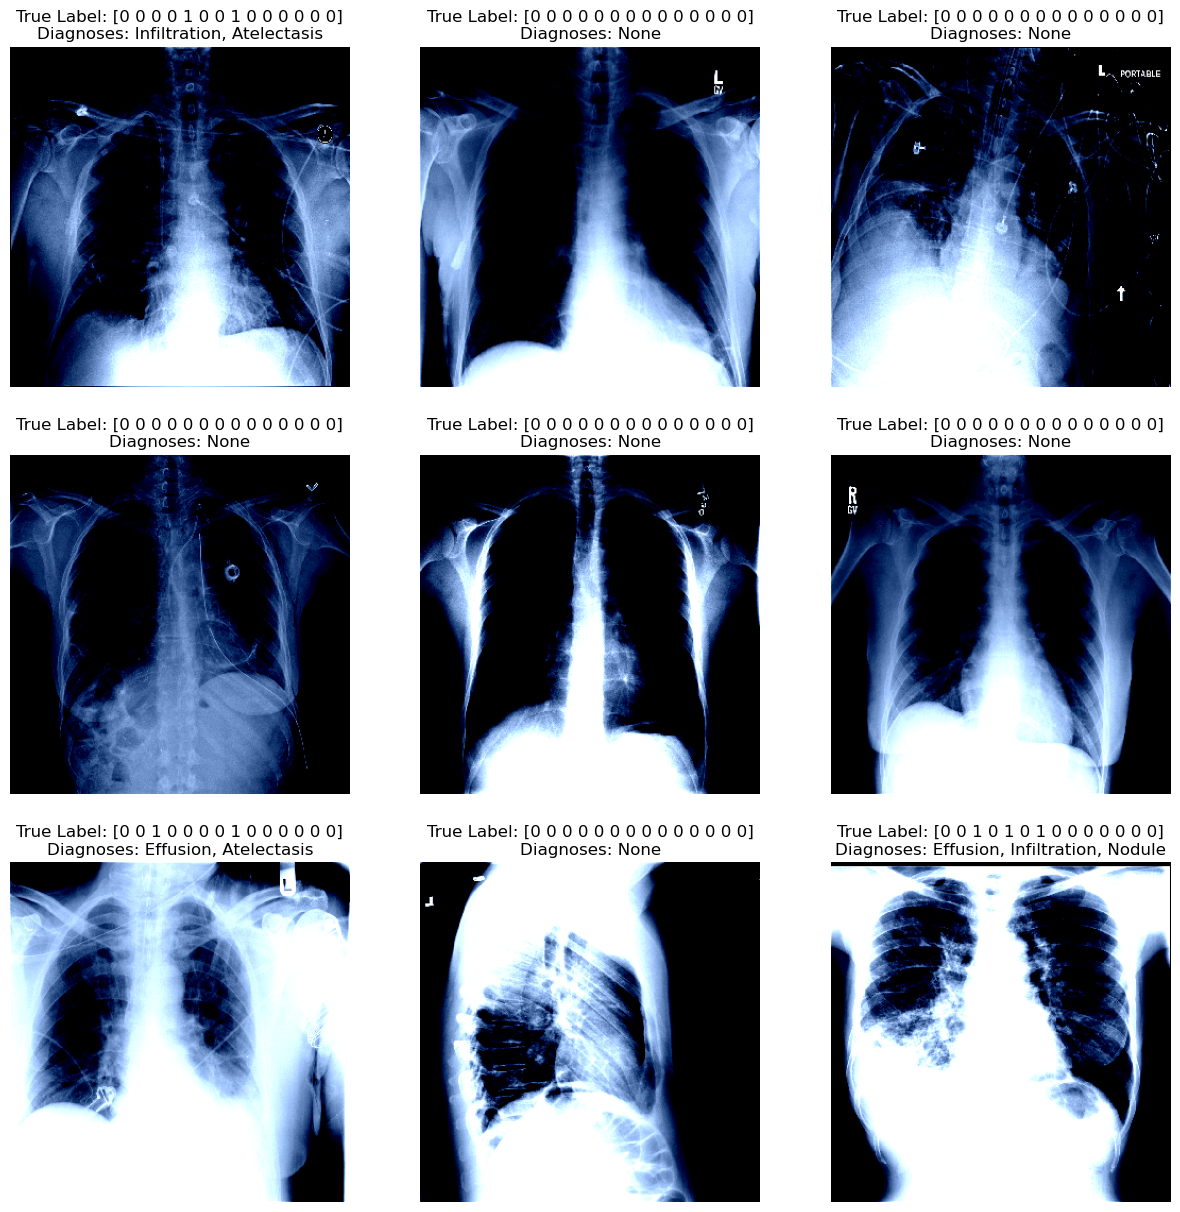

2024-10-04 02:58:32.552867: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Display the first 9 images in the batch along with their corresponding diagnoses
for image_batch, label_batch in train_generator.take(1):  # Take 1 batch of images and labels
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image_batch[i]))  # Display the image
        
        # Extract the label for the current image (shape: [14])
        binary_label = label_batch[i].numpy()
        
        # Find the diagnoses corresponding to labels with 1s
        diagnoses = [labels[j] for j in range(len(binary_label)) if binary_label[j] == 1]
        
        # Create a title showing the binary label and the diagnoses
        if diagnoses:
            title_text = f"True Label: {binary_label}\nDiagnoses: {', '.join(diagnoses)}"
        else:
            title_text = f"True Label: {binary_label}\nDiagnoses: None"
        
        plt.title(title_text)  # Set the title
        plt.axis('off')  # Hide the axis
    
    plt.show()

# Create The Model

<a name='4-1'></a>
### 4.1 Training on the Larger Dataset

Given that the original dataset is 40GB+ in size and the training process on the full dataset takes a few hours, we have trained the model on a GPU-equipped machine for you and provided the weights file from our model (with a batch size of 32 instead) to be used for the rest of this assignment.

The model architecture for our pre-trained model is exactly the same, but we used a few useful Keras "callbacks" for this training. Do spend time to read about these callbacks at your leisure as they will be very useful for managing long-running training sessions:

1. You can use `ModelCheckpoint` callback to monitor your model's `val_loss` metric and keep a snapshot of your model at the point.
2. You can use the `TensorBoard` to use the Tensorflow Tensorboard utility to monitor your runs in real-time.
3. You can use the `ReduceLROnPlateau` to slowly decay the learning rate for your model as it stops getting better on a metric such as `val_loss` to fine-tune the model in the final steps of training.
4. You can use the `EarlyStopping` callback to stop the training job when your model stops getting better in it's validation loss. You can set a `patience` value which is the number of epochs the model does not improve after which the training is terminated. This callback can also conveniently restore the weights for the best metric at the end of training to your model.

You can read about these callbacks and other useful Keras callbacks [here](https://keras.io/callbacks/).


Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.

Like this:

<img src="imgs/densenet.png" alt="U-net Image" width="400" align="middle"/>

For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

$Precision = \frac{TP}{TP+FP}$
    
    1.	Low Precision (0.1347):
	•	A low precision value indicates that the model has a high number of false positives, meaning it is incorrectly predicting a large number of samples as positive when they are actually negative.
	•	This can happen if the model is too sensitive and tends to classify many samples as positive.

$Sensitivity = Recall = \frac{TP}{TP+FN}$

	2.	High Recall (0.6119):
	•	A higher recall value suggests that the model is good at identifying actual positive labels.
	•	However, this often comes at the cost of precision, as the model might be predicting too many positives ... which makes me wonder about the weighting scheme

In [18]:
# create the base pre-trained model
# base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(target_w, target_h, 3))
# base_model = tf.keras.applications.DenseNet121(weights='models/nih/densenet.hdf5', include_top=False, input_shape=(target_w, target_h, 3))
base_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(target_w, target_h, 3))

base_model.trainable = False

In [19]:
# the model itself
# ================
x = base_model.output

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# added to address gross overfitting
x = tf.keras.layers.Dropout(0.7)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after dense layer
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# and a logistic layer
predictions = tf.keras.layers.Dense(len(labels), activation="sigmoid",
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, 
              loss=get_weighted_loss(pos_weights, neg_weights),
                 metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      #tf.keras.metrics.AUC(name='auc_roc'),  # ROC AUC Score
                      #tf.keras.metrics.FalseNegatives(name='false_neg'),
                      #tf.keras.metrics.FalsePositives(name='false_pos')
                  ])

In [21]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=3,
                                                 verbose=1,
                                                 mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  verbose=1,
                                                  mode='min',
                                                  restore_best_weights=True)



history = model.fit(train_generator, batch_size=batch_size,
                    validation_data=valid_generator,
                    epochs = 2000,
                    callbacks=[early_stopping])

Epoch 1/2000


I0000 00:00:1728010727.296463   17983 service.cc:146] XLA service 0x7efa0c0d4440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728010727.296494   17983 service.cc:154]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-04 02:58:47.663932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 02:58:50.089325: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 4/62 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - cat_acc: 0.0000e+00 - loss: 1.3365 - precision: 0.0557 - recall: 0.6581

I0000 00:00:1728010742.483770   17983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - cat_acc: 0.0621 - loss: 1.3769 - precision: 0.0510 - recall: 0.5929

2024-10-04 02:59:24.116317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4829', 16 bytes spill stores, 16 bytes spill loads

2024-10-04 02:59:29.483200: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4829', 4 bytes spill stores, 4 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 508ms/step - cat_acc: 0.0622 - loss: 1.3766 - precision: 0.0509 - recall: 0.5926 - val_cat_acc: 0.0367 - val_loss: 1.0932 - val_precision: 0.0511 - val_recall: 0.4568
Epoch 2/2000
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - cat_acc: 0.0579 - loss: 1.2399 - precision: 0.0467 - recall: 0.5169 - val_cat_acc: 0.1101 - val_loss: 1.0867 - val_precision: 0.0484 - val_recall: 0.4198
Epoch 3/2000
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - cat_acc: 0.0630 - loss: 1.1465 - precision: 0.0497 - recall: 0.5356 - val_cat_acc: 0.0826 - val_loss: 1.0845 - val_precision: 0.0439 - val_recall: 0.3704
Epoch 4/2000
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - cat_acc: 0.0495 - loss: 1.1121 - precision: 0.0466 - recall: 0.5171 - val_cat_acc: 0.0550 - val_loss: 1.0816 - val_precision: 0.0424 - val_recall: 0.3457
Epoch 5/2000
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - cat_acc: 0.0489 - loss: 1.0971 - precision: 0.0489 - recall: 0.5233 - val_cat_acc: 0.0367 - val_loss: 1.0783 - val_preci

In [22]:
history.history.keys()

dict_keys(['cat_acc', 'loss', 'precision', 'recall', 'val_cat_acc', 'val_loss', 'val_precision', 'val_recall'])

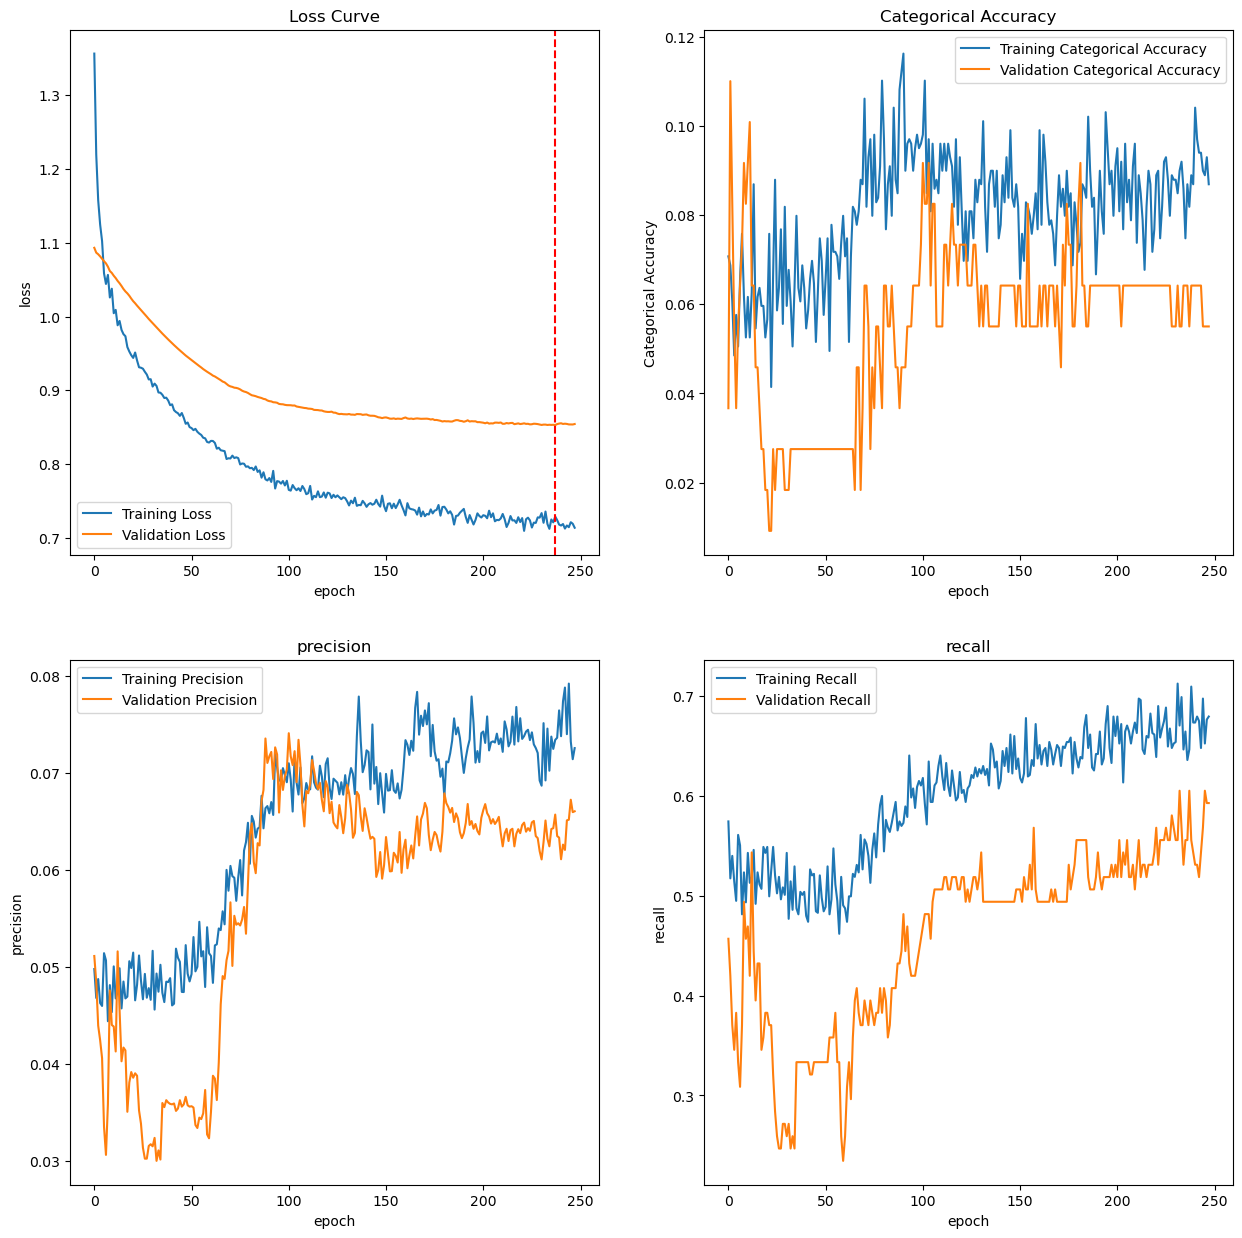

In [23]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
    
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(history.history['loss'],     label="Training Loss")
ax1.plot(history.history['val_loss'], label="Validation Loss")
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.legend()
ax1.axvline(x=early_stopping.best_epoch, color='red', linestyle='--')
ax1.set_title("Loss Curve")

ax2.plot(history.history['cat_acc'],     label="Training Categorical Accuracy")
ax2.plot(history.history['val_cat_acc'], label="Validation Categorical Accuracy")
ax2.set_ylabel("Categorical Accuracy")
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_title("Categorical Accuracy")

ax3.plot(history.history['precision'],     label="Training Precision")
ax3.plot(history.history['val_precision'], label="Validation Precision")
ax3.set_ylabel("precision")
ax3.set_xlabel("epoch")
ax3.legend()
ax3.set_title("precision")

ax4.plot(history.history['recall'],     label="Training Recall")
ax4.plot(history.history['val_recall'], label="Validation Recall")
ax4.set_ylabel("recall")
ax4.set_xlabel("epoch")
ax4.legend()
ax4.set_title("recall")

plt.show()


In [24]:
# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Assign labels to the results based on the order in which metrics are defined in model.compile
metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']

# Print each metric with its corresponding label
for metric, value in zip(metrics, results):
    print(f"{metric}: {value:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - cat_acc: 0.0846 - loss: 1.0549 - precision: 0.1492 - recall: 0.7672
loss: 1.0661
categorical_accuracy: 0.1048
precision: 0.1486
recall: 0.7581


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
y_pred = model.predict(test_generator)

# X_list = []
y_list = []

# Iterate through the dataset and extract features and labels
for _, labls in test_generator:
    # X_list.append(features.numpy())  # Convert the features to a NumPy array and add to the list
    y_list.append(labls.numpy())     # Convert the labels to a NumPy array and add to the list

# Concatenate all batches to form the full dataset
# X = np.concatenate(X_list, axis=0)
y_true = np.concatenate(y_list, axis=0).astype(np.int32)
y_pred = y_pred.astype(np.int32)

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step
                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00        50
         Emphysema       0.00      0.00      0.00        56
          Effusion       0.00      0.00      0.00        53
            Hernia       0.00      0.00      0.00        50
      Infiltration       0.00      0.00      0.00        59
              Mass       0.00      0.00      0.00        60
            Nodule       0.00      0.00      0.00        54
       Atelectasis       0.00      0.00      0.00        60
      Pneumothorax       0.00      0.00      0.00        55
Pleural_Thickening       0.00      0.00      0.00        58
         Pneumonia       0.00      0.00      0.00        50
          Fibrosis       0.00      0.00      0.00        61
             Edema       0.00      0.00      0.00        50
     Consolidation       0.00      0.00      0.00        53

         micro avg       0.00      0.00      0.00       

2024-10-04 03:11:57.456470: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ec2-user/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted

Total number of samples 420


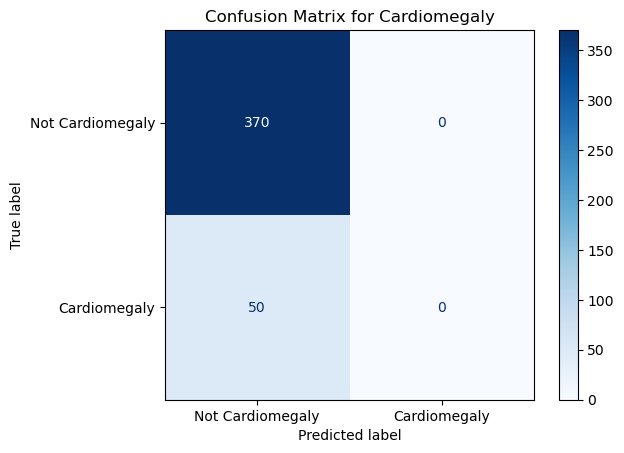

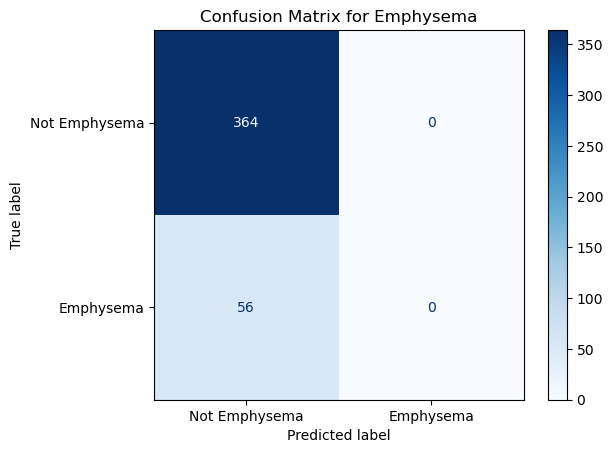

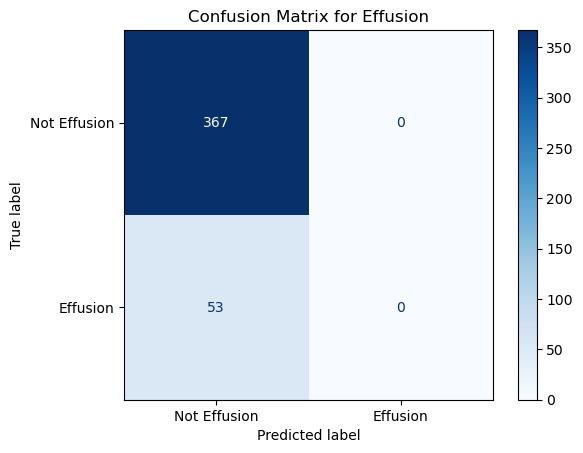

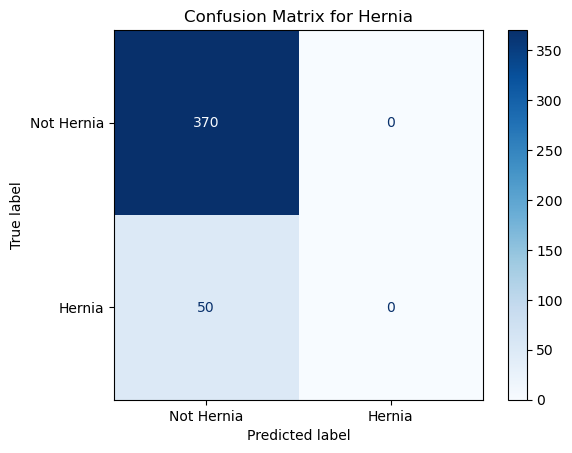

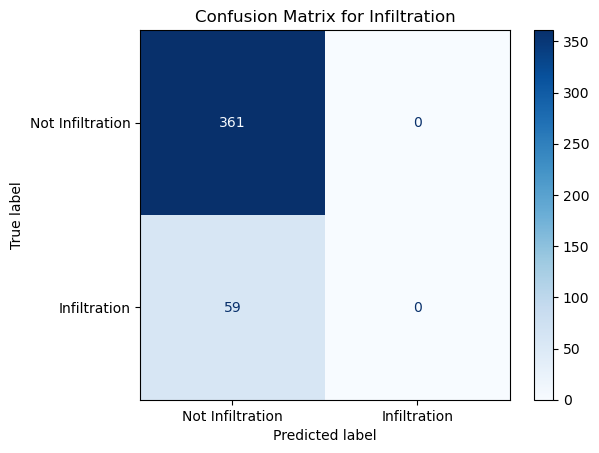

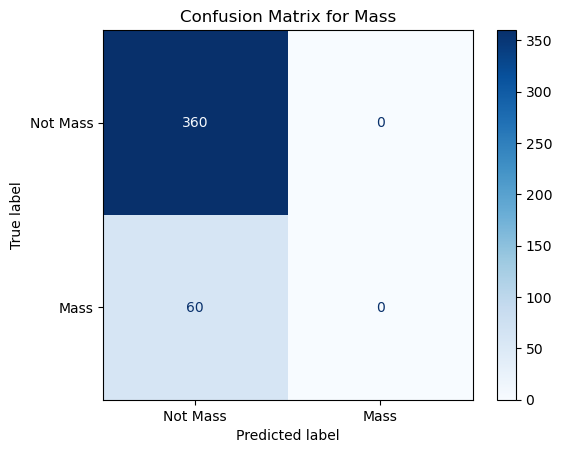

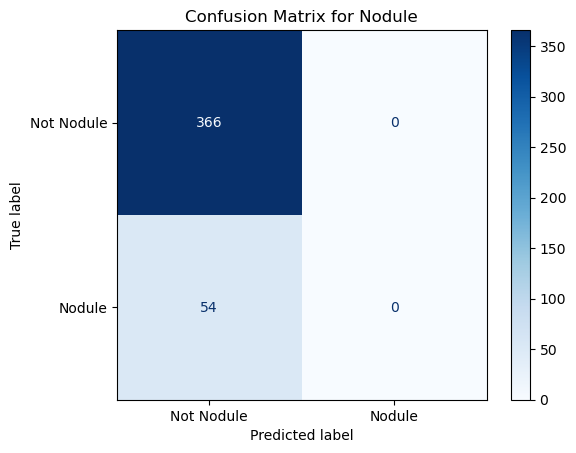

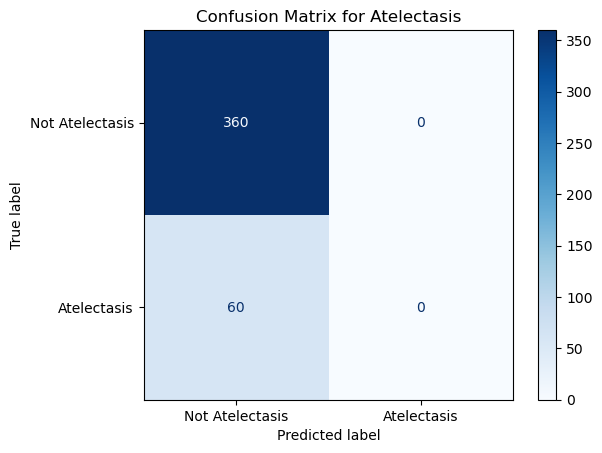

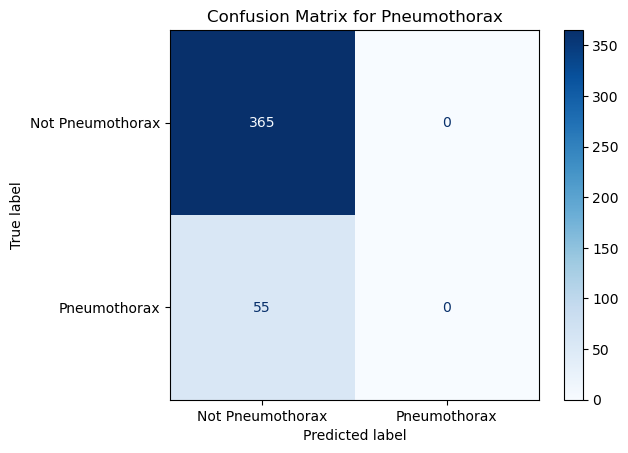

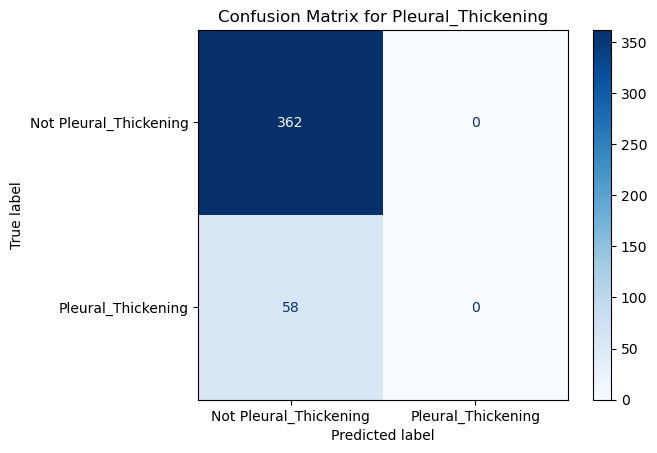

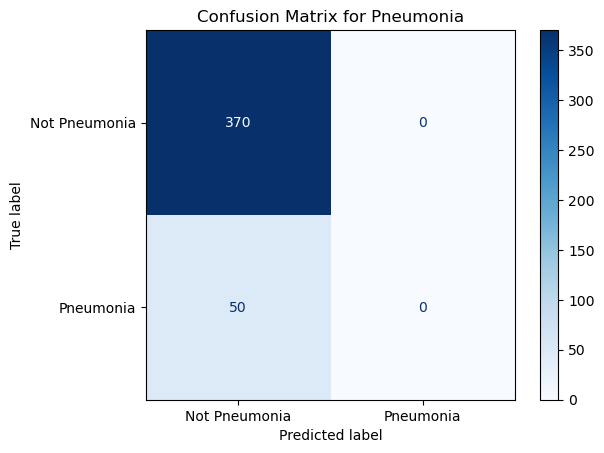

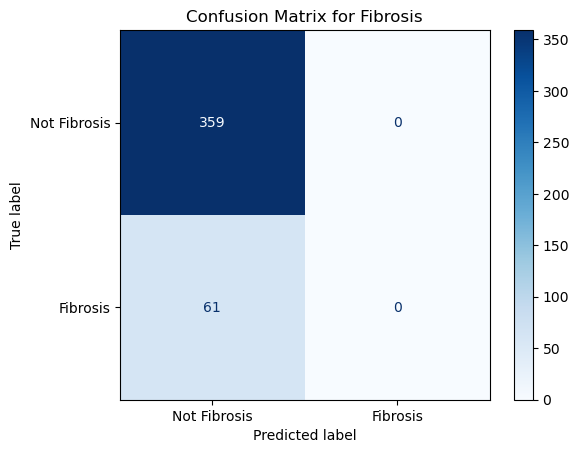

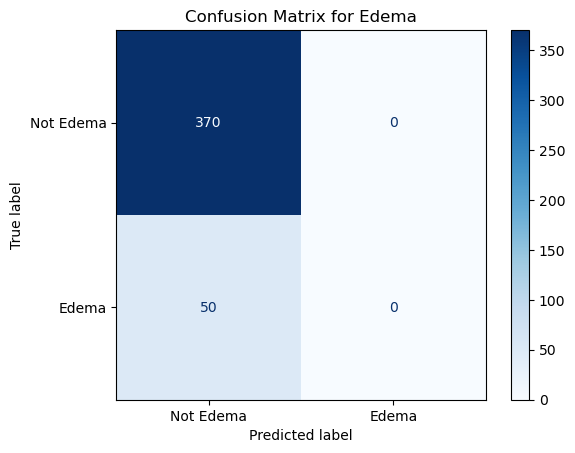

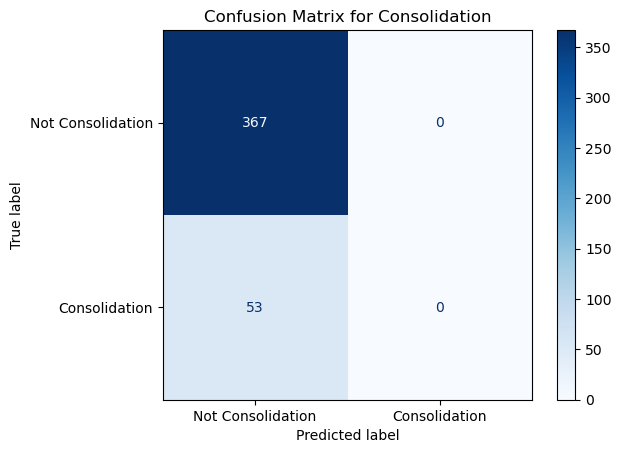

In [26]:
print(f"Total number of samples {y_true.shape[0]}")

# Iterate over each class and compute the confusion matrix
for i, class_name in enumerate(labels):
    # Extract the true and predicted labels for the current class
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    # Compute the confusion matrix for the current class
    cm = confusion_matrix(y_true_class, y_pred_class)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {class_name}', class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()